# Day 5: Agents & Multi-Agent Systems (MAS)

**Goal for today**

| 🔍 Topic | 📚 What you’ll learn | 🛠️ Hands-on |
|----------|----------------------|-------------|
| Agents recap | How an agent decides when to call a *tool* | Build a fresh tool and plug it into a ReAct agent |
| Multi-Agent Systems | Why multiple specialized agents can outperform one big agent | Assemble two specialized agents + a router into a simple MAS graph |
| Project proposals | Form teams and sketch your capstone idea | Pitch in a 2-slide deck or whiteboard |

> **Skill level:** beginner ➜ intermediate Python  
> **Prereqs:** Day 3 (single agents) & Day 4 (LangGraph workflows)



+ https://langchain-ai.github.io/langgraph/concepts/multi_agent/

In [16]:
# ------------------------------------------------------------
# ⚙️ Cell: Install / Imports (run once at the top of Colab/Jupyter)
# ------------------------------------------------------------
# !pip install langgraph langchain-openai python-dotenv wikipedia rich --quiet

import os
from dotenv import load_dotenv
load_dotenv()                               # make sure your .env has OPENAI_API_KEY / OPENAI_ORGANIZATION

from typing import TypedDict, Literal
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, Markdown

In [2]:
# Choose a small, inexpensive model for demos. Feel free to swap later.
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.environ.get("OPENAI_ORGANIZATION")
LLM = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=OPENAI_API_KEY,
    openai_organization=OPENAI_ORGANIZATION,
    temperature=0
)
print("✅ LLM ready ✔︎")

✅ LLM ready ✔︎


## 1 ⟶ Quick recap: What is an *Agent*?

* An **agent** is an LLM wrapped in decision-making logic.  
* It inspects the user question → decides whether to answer directly or call a **tool**.  
* Tools are just normal Python functions registered with the `@tool` decorator.

### Where MAS fits in

| Single agent | Multi-Agent System |
|--------------|-------------------|
| One toolbelt, one reasoning loop | Several *specialist* agents + *coordinator* |
| Good for simple tasks | Scales to complex, multi-step workflows |


In [6]:
# -----------------------------------------------------------------
# 🛠️ Cell: Build our first *new* tool of the day – a unit converter
# -----------------------------------------------------------------
@tool
def celsius_to_fahrenheit(c: float) -> str:
    """
    Convert °C to °F and explain the formula.
    """
    f = (c * 9/5) + 32
    return f"{c}°C is {f:.1f}°F.  (Formula: F = C × 9/5 + 32)"

## Step 2: Single-Agent refresher (ReAct pattern)

The ReAct agent thinks *step-by-step* (just like on Day 3) using **Thought → Action → Observation → Answer**.


In [8]:
# ------------------------------------------------------------
# 🤖 Cell: Build a quick single agent with the new converter tool
# ------------------------------------------------------------
tools   = [celsius_to_fahrenheit]
react_agent = create_react_agent(LLM, tools)

react_agent.invoke({"messages": "Convert 25 Celsius to Fahrenheit, please"})

{'messages': [HumanMessage(content='Convert 25 Celsius to Fahrenheit, please', additional_kwargs={}, response_metadata={}, id='3771bf07-1a4d-4b59-8ad0-ac9030186774'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xMF9qwGevr2vTJ0SnUagPXRe', 'function': {'arguments': '{"c":25}', 'name': 'celsius_to_fahrenheit'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 59, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2d877195-a077-467d-b87e-5aa5b95bb30a-0', tool_calls=[{'name': 'celsius_to_fahrenheit', 'args': {'c': 25}, 'id': 'call_xMF9qwGevr2vTJ0SnUagPXRe', 'type': 'tool_call'}], usage_meta

## Step 3: Designing a Multi-Agent System

We’ll create **two specialists**:

1. **MathAgent** – handles arithmetic with a calculator tool  
2. **WikiAgent** – fetches short Wikipedia summaries with a wiki tool  

A **Router** node (also an LLM) will read the user’s question and decide *which* specialist to send it to.  
Finally, a **Gather** node simply forwards the chosen agent’s answer back to the user.

In [11]:
# ------------------------------------------------------------
# 🛠️ Cell: Specialist tools
# ------------------------------------------------------------
# 1) Calculator
@tool
def add(x: float, y: float) -> float:
    """Add two numbers."""
    return x + y

@tool
def multiply(x: float, y: float) -> float:
    """Multiply two numbers."""
    return x * y

# 2) Wikipedia search (uses the wikipedia Python package)
import wikipedia

@tool
def wiki_summary(topic: str, sentences: int = 2) -> str:
    """
    Grab a short summary from Wikipedia.
    """
    return wikipedia.summary(topic, sentences=sentences)

# Keep tool lists separate for clarity
math_tools = [add, multiply]
wiki_tools = [wiki_summary]

In [13]:
# ------------------------------------------------------------
# 🤖 Cell: Build the specialist agents
# ------------------------------------------------------------
math_agent = create_react_agent(
    LLM, math_tools
)

wiki_agent = create_react_agent(
    LLM, wiki_tools
)

# Helper lookup so the Router can call by name
AGENTS = {
    "math": math_agent,
    "wiki": wiki_agent
}

## Step 4: Router: deciding which agent to use

We’ll keep routing logic *inside* an LLM for flexibility.  
The model outputs a label **"math"** or **"wiki"** that maps to one of our AGENTS.

In [18]:
# ------------------------------------------------------------
# 🧭 Cell: Router node – classification with LLM
# ------------------------------------------------------------
class Route(BaseModel):
    destination: Literal["math", "wiki"]
    reasoning: str                           # for transparency

def router_fn(question: str) -> Route:
    prompt = f"""
    Classify the user question into one label:
    - "math"  → if it involves arithmetic or units/measurements
    - "wiki" → if it asks for factual or encyclopedic info

    Respond ONLY with the label, nothing else.

    Question: {question}
    """
    label = LLM.invoke(prompt).content.strip().lower()
    if label not in ["math", "wiki"]:
        label = "wiki"                       # default fallback
    return Route(destination=label, reasoning=f"LLM chose '{label}'.")

In [20]:
# ------------------------------------------------------------
# 🗺️ Cell: Construct the MAS graph in LangGraph
# ------------------------------------------------------------
class State(TypedDict):
    question: str
    route: Route
    answer: str

mas = StateGraph(State)

# Node 1 – Router
def router_node(state: State) -> State:
    state["route"] = router_fn(state["question"])
    return state
mas.add_node("router", router_node)

# Node 2 – MathAgent wrapper
def math_node(state: State) -> State:
    response = AGENTS["math"].invoke({"messages": state["question"]})
    state["answer"] = response["messages"][-1].content
    return state
mas.add_node("MathAgent", math_node)

# Node 3 – WikiAgent wrapper
def wiki_node(state: State) -> State:
    response = AGENTS["wiki"].invoke({"messages": state["question"]})
    state["answer"] = response["messages"][-1].content
    return state
mas.add_node("WikiAgent", wiki_node)

# Conditional edges based on router output
mas.add_conditional_edges(
    "router",
    lambda s: s["route"].destination,        # returns "math" or "wiki"
    {
        "math": "MathAgent",
        "wiki": "WikiAgent"
    }
)

# Terminal edge: both specialists go to END
mas.add_edge(START, "router")
mas.add_edge("MathAgent", END)               # END is a special sentinel in LangGraph
mas.add_edge("WikiAgent", END)

graph = mas.compile()

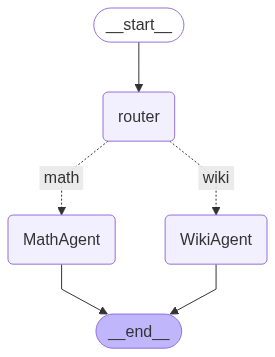

In [21]:
Image(graph.get_graph().draw_mermaid_png())

In [23]:
# ------------------------------------------------------------
# 🚀 Cell: Try it out!
# ------------------------------------------------------------
examples = [
    "What is 7.5 times 12?",
    "Who wrote *The Great Gatsby*?",
    "Add 42 and 19",
    "Tell me about the Eiffel Tower"
]

for q in examples:
    print("\n🔸 Question:", q)
    result = graph.invoke({"question": q})
    print("🤖 Answer:", result["answer"])
    print("🧠 Route chosen:", result["route"])
    print()
    # break # uncomment to just run one question


🔸 Question: What is 7.5 times 12?
🤖 Answer: 7.5 times 12 is 90.0.
🧠 Route chosen: destination='math' reasoning="LLM chose 'math'."


🔸 Question: Who wrote *The Great Gatsby*?
🤖 Answer: *The Great Gatsby* was written by F. Scott Fitzgerald.
🧠 Route chosen: destination='wiki' reasoning="LLM chose 'wiki'."


🔸 Question: Add 42 and 19
🤖 Answer: The sum of 42 and 19 is 61.
🧠 Route chosen: destination='math' reasoning="LLM chose 'math'."


🔸 Question: Tell me about the Eiffel Tower
🤖 Answer: The Eiffel Tower is a wrought-iron lattice tower located on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and constructed the tower between 1887 and 1889.
🧠 Route chosen: destination='wiki' reasoning="LLM chose 'wiki'."



## Step 5: Hands-on exercise

1. **Write your own tool**  
   - Ideas: `fahrenheit_to_celsius`, simple algebra solver, currency converter (fake FX rates).  
   - Decorate with `@tool` and add it to a *new* specialist agent.

2. **Extend the router**  
   - Add a new label, e.g. `"convert"`, and update `router_fn` plus `AGENTS`.

3. **Run at least three user queries** that exercise **all** of your specialists.

4. **Stretch goal** ⭐  
   - Make the Router return *both* a destination **and** an *explanation* of why it chose that agent, then include that reasoning in your final answer.